# Topic Modelling on Encrpyted Twitter Dataset
*Author: Yasir Abdur Rohman*
<hr>

# Introduction
In this notebook, I will implement Topic Modelling with Latent Dirichlet on Encrypted Twitter Dataset. 

Twitter is one of the social media that has followed the GDPR rules to protect the privacy of each user. However, we can still access tweets from many users by using the Twitter API. Even though there is an agreement to use the Twitter API wisely, it will still damage the privacy of other users who don't want their tweets to be taken. Therefore, here we will implement Encrypted Twitter Dataset as a privacy protection from the user.

And after we encrypt the Twitter dataset, we can still implement AI securely. Here, we will apply Topic Modeling to uncover abstract themes based on the underlying tweet documents and words in a corpus of text.

The project consists of the following steps:
1. Crawling Twitter Dataset
2. Exploratory Data Analysis
3. Implement Encrypted Twitter Dataset
4. Topic Modelling

# Step 1: Crawling Twitter Dataset

In [34]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import time

# import dotenv
import os
from dotenv import load_dotenv

# import tweepy
import tweepy

# datetime
from datetime import datetime, timedelta

# plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True) #do not miss this line

# gensim
from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")

We need Twitter API to crawl Twitter dataset. So, let's setting up for Twitter crawler first. 

In [35]:
# load env file
load_dotenv(".env")

# setting API Twitter
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In this project, we can setting up some parameters as follows:
- **maximum_days:** the age of the tweet document from the current time.
- **query:** keywords for searching tweet documents

In [36]:
# initialize crawler parameters

# date
maximum_days = 7 # 7 days, so we will get all of the tweet documents from 7 days before
today = datetime.today()
date_max = today - timedelta(days=maximum_days)

# query
query = "#Udacity OR #udacity OR Udacity OR udacity"

Next, we will save the results of crawling the tweet document into the <code>pandas dataframe</code> .

The fields from the tweet document that we will obtain are as follows:
- **username:** users
- **created_at:** the date when the tweet created
- **text:** text of the tweet

In [37]:
# initialize dataframe
df_tweet = pd.DataFrame({'username': [], 'created_at': [], 'text': []})

# crawling tweet documents
c = tweepy.Cursor(api.search, q=query, tweet_mode='extended').items()
while True:
    try:
        tweet = c.next()
        
        # get clean tweet without RT
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            username = tweet.user.screen_name
            created = tweet.created_at
            text = tweet.full_text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

            # get tweet documents before maximum_days
            if tweet.created_at < date_max:
                break
            df_tweet = df_tweet.append({'username': username, 'created_at': created, 
                                        'text': text}, ignore_index=True)
                       
    except tweepy.TweepError as e:
        print(e.reason)
        time.sleep(15 * 60)
        continue
    except StopIteration:
        break

# Step 2: Exploratory Data Analysis

In [38]:
# let's see our twitter dataset
df_tweet.head(10)

,username,created_at,text
0,JustNowBulletin,2019-08-20 14:20:11,Udacity AWS DeepRacer Scholarship Challenge fo...
1,sustaintrain,2019-08-20 14:15:10,A new Udacity Green IT training course has bee...
2,Upwork,2019-08-20 13:20:49,Back to School Isn’t Just For Kids: 20 Courses...
3,frengki_17,2019-08-20 13:17:23,@onnowpurbo Belajar tensorflow yang di udacity...
4,javaquantum,2019-08-20 13:14:13,@xsahil03x @GoogleIndia @udacity Congratulatio...
5,RahulSi88662093,2019-08-20 13:08:38,@anandjha_98 @kala83 @Google @udacity Please r...
6,MaramAlroshoud,2019-08-20 12:49:10,وشو مسك يوداستي؟ — https://t.co/UC0Y4m9Foo htt...
7,SafeScholarship,2019-08-20 12:29:52,Udacity AWS DeepRacer Scholarship Challenge fo...
8,0xAlsharif,2019-08-20 12:29:09,Networking for Web Developers. https://t.co/Hf...
9,0xAlsharif,2019-08-20 12:19:33,تحية وتقدير للمواقع والمصادر التعليمية اللي تج...


In [39]:
# let's counting how many tweet documents that we got
print("The number of tweet documents:", len(df_tweet['text']))

The number of tweet documents: 493


## Visualizing The Number of Tweets for each day

In [40]:
tweetsT = df_tweet['created_at'] 

trace = go.Histogram(
    x = tweetsT,
    marker = dict(
        color = 'blue'
    ),
    opacity = 0.75
)

layout = go.Layout(
    title = 'Tweet Activity',
    height = 450,
    width = 1000,
    xaxis = dict(
        title = 'Date'
    ),
    yaxis = dict(
        title = 'Tweet Quantity'
    ),
    bargap = 0.2,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

# Step 3: Implement Encrpyted Dataset

First, we create dictionaries to change for each character to index, and vice versa.

In [41]:
char2index = {}
index2char = {}

for i, char in enumerate(' ' + string.ascii_lowercase + '0123456789' + string.punctuation):
    char2index[char] = i
    index2char[i] = char

Let's build some functions to implement encrpyted dataset.

In [42]:
def string2values(str_input, max_len=8):
    """Change string to value.
    Args:
        str_input(str): string input
        max_len: maximum length of string
    Returns:
        tensor values
    """
    str_input = str_input[:max_len].lower()
    
    # pad strings shorter than max len
    if(len(str_input) < max_len):
        str_input = str_input + "." * (max_len - len(str_input))
    
    values = list()
    for char in str_input:
        values.append(char2index[char])
        
    return th.tensor(values).long()

def values2string(input_values):
    """Change value to string.
    Args:
        input_values: values input
    Returns:
        string
    """
    s = ""
    for value in input_values:
        s += index2char[int(value)]
    return s

def one_hot(index, length):
    """Make one hot for each counted string on the index.
    Args:
        index
    Returns:
        one hot vector
    """
    vect = th.zeros(length).long()
    vect[index] = 1
    return vect

def string2one_hot_matrix(str_input, max_len=8):
    """Change string into one hot matrix
    Args:
        str_input(str): string input
        max_len: maximum length of string
    Returns:
        one hot matrix
    """
    str_input = str_input[:max_len].lower()
    # pad strings shorter than max len
    if(len(str_input) < max_len):
        str_input = str_input + "." * (max_len - len(str_input))

    char_vectors = list()
    for char in str_input:
        char_v = one_hot(char2index[char], len(char2index)).unsqueeze(0)
        char_vectors.append(char_v)
        
    return th.cat(char_vectors, dim=0)

def strings_equal(str_a, str_b):
    """Comparing two string inputs
    Args:
        str_a(str): string input a
        str_b(str): string input b
    Returns:
        tensor comparison result
    """
    vect = (str_a * str_b).sum(1) # show overlapping

    x = vect[0]

    for i in range(vect.shape[0] - 1):
        x = x * vect[i+1]

    return x

Now, we will make class <code>EncrpytedDataset</code> to encrypt Twitter dataset.

In [46]:
class EncryptedDataset():
    
    def __init__(self, *owners, max_key_len=8, max_val_len=8):
        self.max_key_len = max_key_len
        self.max_val_len = max_val_len
        
        self.keys = list()
        self.values = list()
        self.owners = owners
        
    def add_entry(self, key, value):
        key = string2one_hot_matrix(key)
        key = key.share(*self.owners)
        self.keys.append(key)
        
        value = string2values(value, max_len=self.max_val_len)
        value = value.share(*self.owners)
        self.values.append(value)
        
    def query(self, query_str):
        query_matrix = string2one_hot_matrix(query_str)
        
        query_matrix = query_matrix.share(*self.owners)

        key_matches = list()
        for key in self.keys:

            key_match = strings_equal(key, query_matrix)
            key_matches.append(key_match)

        result = self.values[0] * key_matches[0]

        for i in range(len(self.values) - 1):
            result += self.values[i+1] * key_matches[i+1]
            
        result = result.get()

        return values2string(result).replace(".","")

## Make workers

In [44]:
import syft as sy
import torch as th
hook = sy.TorchHook(th)

W0820 22:11:36.020632  2788 hook.py:98] Torch was already hooked... skipping hooking process


In [63]:
bob = sy.VirtualWorker(hook, id="bob").add_worker(sy.local_worker)
alice = sy.VirtualWorker(hook, id="alice").add_worker(sy.local_worker)
secure_worker = sy.VirtualWorker(hook, id="secure_worker").add_worker(sy.local_worker)

# clearing objects
bob = bob.clear_objects()
alice = alice.clear_objects()
secure_worker = secure_worker.clear_objects()

W0820 22:34:05.893684  2788 base.py:628] Worker me already exists. Replacing old worker which could cause                     unexpected behavior
W0820 22:34:05.894680  2788 base.py:628] Worker me already exists. Replacing old worker which could cause                     unexpected behavior
W0820 22:34:05.895643  2788 base.py:628] Worker me already exists. Replacing old worker which could cause                     unexpected behavior


## Cleaning Dataset

In [49]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
import string
from unicodedata import normalize
import re

def remove_url(tweet):
    """Remove URL link.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = re.sub(r"\s—\s", "", tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_hashtag_mention(tweet):
    """Remove hastag and mention.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    result = []
    tweet = tweet.split(' ')
    for t in tweet:
        if t.startswith('#') or t.startswith('@'):
            continue
        else:
            result.append(t)
    return ' '.join(result)

def remove_rt_fav(tweet):
    """Remove RT and FAV.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = re.sub(r'^(RT|FAV)','', tweet)
    return tweet

def remove_punctuation(tweet):
    """Remove punctuation except '-'.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    remove = string.punctuation
    translator = str.maketrans(remove, ' '*len(remove))
    return tweet.translate(translator)
    
def remove_ascii_unicode(tweet):
    """Remove ASCII and Unicode.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = normalize('NFKD', tweet)
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    return tweet

def remove_newline(tweet):
    """Remove newline.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = tweet.replace('\n', ' ')
    return tweet

[nltk_data] Downloading package stopwords to C:\Users\Yasir Abdur
[nltk_data]     Rohman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# cleaning tweet documents

for index, row in df_tweet.iterrows():
    clean_tweet = remove_ascii_unicode(row['text'])
    clean_tweet = clean_tweet.lower()
    clean_tweet = remove_rt_fav(clean_tweet)
    clean_tweet = remove_newline(clean_tweet)
    clean_tweet = remove_url(clean_tweet)
    clean_tweet = remove_hashtag_mention(clean_tweet)
    clean_tweet = remove_punctuation(clean_tweet)
    
    # update dataframe
    df_tweet.at[index,'text'] = clean_tweet

In [52]:
# take a look at the results
df_tweet['text'].head(10)

0    udacity aws deepracer scholarship challenge fo...
1    a new udacity green it training course has bee...
2    back to school isnt just for kids  20 courses ...
3    belajar tensorflow yang di udacity bagus gak pak 
4                                    congratulations  
5              please reach out at support udacity com
6                                                     
7    udacity aws deepracer scholarship challenge fo...
8                     networking for web developers   
9                                                     
Name: text, dtype: object

## Encrpyt the dataset

In [66]:
# initialize class EncrpytedDataset
db = EncryptedDataset(bob, alice, secure_worker, max_val_len=280)

# add Twitter dataset into db
for index, row in df_tweet.iterrows():
    # we can make the key combining index and username
    key = str(index) + '@' + row['username']
    values = row['text']
    
    db.add_entry(key, values)

In [67]:
# let's testing out our database
db.query("0@JustNowBulletin")

'udacity aws deepracer scholarship challenge for international students '

In [68]:
# we get the same result
df_tweet.head(1)

,username,created_at,text
0,JustNowBulletin,2019-08-20 14:20:11,udacity aws deepracer scholarship challenge fo...


# Step 4: Topic Modelling
Now, we will implementing Topic Modelling from our Encrpyted Dataset.

In [72]:
# make list of keys
keys = list()

for index, row in df_tweet.iterrows():
    key = str(index) + '@' + row['username']
    keys.append(key)

len(keys)

493

## Make a corpus
We will make corpus from Twitter Encrypted Dataset.

In [77]:
corpus = list()
a = list()

# for i in range(len(df_tweet['text'])):
#     a = df_tweet['text'][i]
#     corpus.append(a)

for key in keys:
    a = db.query(key)
    corpus.append(a)

In [79]:
# let's see our corpus
corpus[0:5]

['udacity aws deepracer scholarship challenge for international students ',
 'a new udacity green it training course has been added to sustaintraina   data engineer     ',
 'back to school isnt just for kids  20 courses to update your skills from and   ',
 'belajar tensorflow yang di udacity bagus gak pak ',
 'congratulations  ']

## Make temporary folder for saving dictionary and corpus

In [80]:
import gensim
import logging
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\YASIRA~1\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


## Remove common words and tokenize

In [81]:
# remove common words and tokenize
common_words = ['RT','rt', 'udacity']
stoplist = stopwords.words('english') + list(punctuation) + common_words

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

## Convert corpus documents into a stream of vectors

In [82]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'tweet_documents.dict'))  # store the dictionary, for future reference
# print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweet_documents.mm'), corpus)  # store to disk, for later use

## Transformation using Tfidf
TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [83]:
# initialize
tfidf = models.TfidfModel(corpus)

In [84]:
# use the model to transform vectors
corpus_tfidf = tfidf[corpus]

## Implement LDA
Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.

In [85]:
num_of_topics = 4

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=num_of_topics)
corpus_lda = lda[corpus_tfidf]

W0820 23:36:28.732566  2788 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


In [89]:
# Show first n important word in the topics
lda.show_topics(num_of_topics, 5)

[(0,
  '0.014*"course" + 0.012*"amp" + 0.010*"new" + 0.007*"training" + 0.006*"congratulations"'),
 (1,
  '0.013*"learning" + 0.011*"nanodegree" + 0.010*"day" + 0.009*"android" + 0.008*"data"'),
 (2,
  '0.007*"nanodegree" + 0.007*"thanks" + 0.007*"learning" + 0.006*"project" + 0.006*"amp"'),
 (3,
  '0.018*"course" + 0.017*"learning" + 0.015*"day" + 0.010*"nanodegree" + 0.009*"machine"')]

In [90]:
# Show probability for each word in each topic
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i, 25)) for i in range(num_of_topics)}

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

df_lda.head()

(71, 4)
(4, 71)


,1,2,3,able,added,ai,also,amp,android,become,...,time,training,two,u,udemy,ur,via,voyage,web,work
0,0.000000,0.000000,0.000000,0.003533,0.005734,0.003379,0.000000,0.011932,0.000000,0.000000,...,0.000000,0.00663,0.00338,0.000000,0.000000,0.000000,0.000000,0.004506,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003571,0.008878,0.003672,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003455
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003593,0.005869,0.000000,0.000000,...,0.003756,0.00000,0.00000,0.003702,0.005444,0.003332,0.000000,0.000000,0.000000,0.000000
3,0.007639,0.009043,0.008026,0.000000,0.000000,0.004154,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.003851,0.000000,0.003543,0.000000


## Visualizing Clustermap LDA

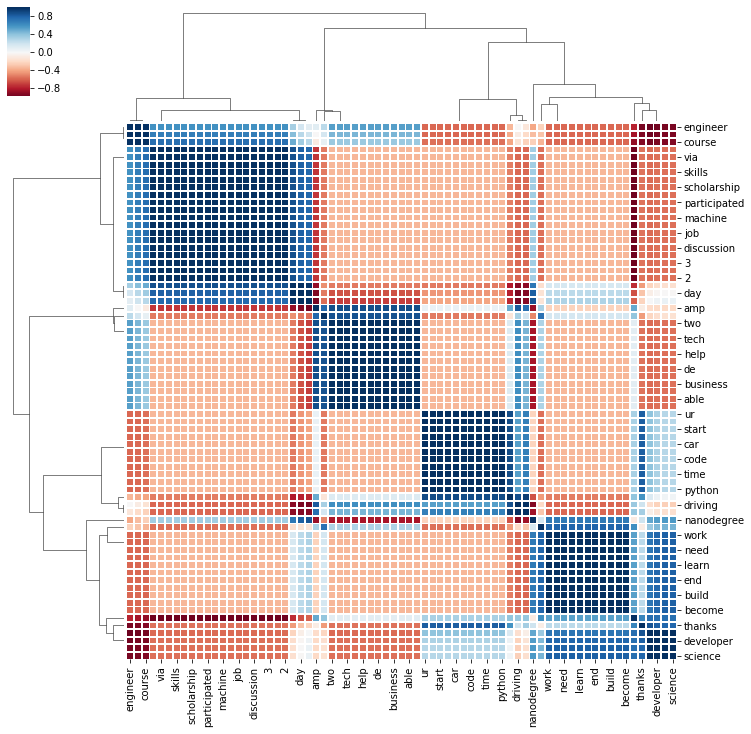

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

## Visualizing with PyLDAvis

In [92]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      717.098206 -274.787933       1        1  61.212318
0     -497.595306 -238.658997       2        1  12.996777
2       91.696190 -863.767029       3        1  12.954168
1      127.807060  350.324554       4        1  12.836737, topic_info=    Category      Freq             Term     Total  loglift  logprob
384  Default  1.000000              amp  1.000000  30.0000  30.0000
11   Default  1.000000              new  1.000000  29.0000  29.0000
163  Default  4.000000       nanodegree  4.000000  28.0000  28.0000
8    Default  1.000000             data  1.000000  27.0000  27.0000
7    Default  6.000000           course  6.000000  26.0000  26.0000
131  Default  0.000000          android  0.000000  25.0000  25.0000
121  Default  6.000000         learning  6.000000  24.0000  24.0000
177  Default  1.000000           thanks  1.000000  23.0000  23.0000
29   Default  0.000000  congratulations  0.000000  22.0000  22.0000
13   Default  1.000000         training  1.000000  21.0000  21.0000
12   Default  0.000000    sustaintraina  0.000000  20.0000  20.0000
166  Default  0.000000          science  0.000000  19.0000  19.0000
379  Default  1.000000        developer  1.000000  18.0000  18.0000
10   Default  0.000000            green  0.000000  17.0000  17.0000
6    Default  0.000000            added  0.000000  16.0000  16.0000
150  Default  1.000000          project  1.000000  15.0000  15.0000
147  Default  5.000000              day  5.000000  14.0000  14.0000
51   Default  1.000000          program  1.000000  13.0000  13.0000
162  Default  1.000000        completed  1.000000  12.0000  12.0000
127  Default  1.000000            udemy  1.000000  11.0000  11.0000
900  Default  0.000000               de  0.000000  10.0000  10.0000
16   Default  1.000000          courses  1.000000   9.0000   9.0000
689  Default  0.000000             help  0.000000   8.0000   8.0000
580  Default  0.000000              end  0.000000   7.0000   7.0000
245  Default  0.000000            build  0.000000   6.0000   6.0000
671  Default  0.000000           voyage  0.000000   5.0000   5.0000
620  Default  1.000000             self  1.000000   4.0000   4.0000
645  Default  1.000000            learn  1.000000   3.0000   3.0000
640  Default  0.000000           become  0.000000   2.0000   2.0000
617  Default  1.000000          driving  1.000000   1.0000   1.0000
..       ...       ...              ...       ...      ...      ...
533   Topic4  0.188341            could  0.372085   1.3720  -5.8172
166   Topic4  0.375340          science  0.784598   1.3155  -5.1276
819   Topic4  0.202087               gb  0.419389   1.3228  -5.7467
165   Topic4  0.246269      programming  0.571765   1.2106  -5.5490
8     Topic4  0.527921             data  1.718537   0.8726  -4.7865
245   Topic4  0.300216            build  0.800375   1.0723  -5.3509
754   Topic4  0.199724            front  0.482997   1.1698  -5.7585
379   Topic4  0.369394        developer  1.165598   0.9037  -5.1435
217   Topic4  0.218626             work  0.551821   1.1270  -5.6680
854   Topic4  0.127035          explore  0.255990   1.3522  -6.2109
467   Topic4  0.239285             need  0.692042   0.9909  -5.5777
850   Topic4  0.189130       artificial  0.491826   1.0972  -5.8130
163   Topic4  0.710112       nanodegree  4.463806   0.2145  -4.4900
851   Topic4  0.162263       autonomous  0.413281   1.1179  -5.9662
162   Topic4  0.335191        completed  1.386456   0.6331  -5.2407
121   Topic4  0.832880         learning  6.782568  -0.0444  -4.3305
147   Topic4  0.660560              day  5.637958  -0.0913  -4.5623
16    Topic4  0.329677          courses  1.519501   0.5248  -5.2573
51    Topic4  0.330654          program  1.834227   0.3396  -5.2543
11    Topic4  0.305914              new  1.579808   0.4111  -5.3321
645   Topic4  0.298989            learn  1.537540   0.4153  -5.3550
177  